### Load Data

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

energy_data = pd.read_csv('data/owid-energy.csv')

energy_data.head()

country  year iso_code  population  gdp  biofuel_cons_change_pct  \
0  Afghanistan  1900      AFG   4832414.0  NaN                      NaN   
1  Afghanistan  1901      AFG   4879685.0  NaN                      NaN   
2  Afghanistan  1902      AFG   4935122.0  NaN                      NaN   
3  Afghanistan  1903      AFG   4998861.0  NaN                      NaN   
4  Afghanistan  1904      AFG   5063419.0  NaN                      NaN   

   biofuel_cons_change_twh  biofuel_cons_per_capita  biofuel_consumption  \
0                      NaN                      NaN                  NaN   
1                      NaN                      NaN                  NaN   
2                      NaN                      NaN                  NaN   
3                      NaN                      NaN                  NaN   
4                      NaN                      NaN                  NaN   

   biofuel_elec_per_capita  ...  solar_share_elec  solar_share_energy  \
0                      NaN  ...               NaN                 NaN   
1                      NaN  ...               NaN                 NaN   
2                      NaN  ...               NaN                 NaN   
3                      NaN  ...               NaN                 NaN   
4                      NaN  ...               NaN                 NaN   

   wind_cons_change_pct  wind_cons_change_twh  wind_consumption  \
0                   NaN                   NaN               NaN   
1                   NaN                   NaN               NaN   
2                   NaN                   NaN               NaN   
3                   NaN                   NaN               NaN   
4                   NaN                   NaN               NaN   

   wind_elec_per_capita  wind_electricity  wind_energy_per_capita  \
0                   NaN               NaN                     NaN   
1                   NaN               NaN                     NaN   
2                   NaN               NaN                     NaN   
3                   NaN               NaN                     NaN   
4                   NaN               NaN                     NaN   

   wind_share_elec  wind_share_energy  
0              NaN                NaN  
1              NaN                NaN  
2              NaN                NaN  
3              NaN                NaN  
4              NaN                NaN  

[5 rows x 129 columns]

### Find energy source for each and filter out 'None'

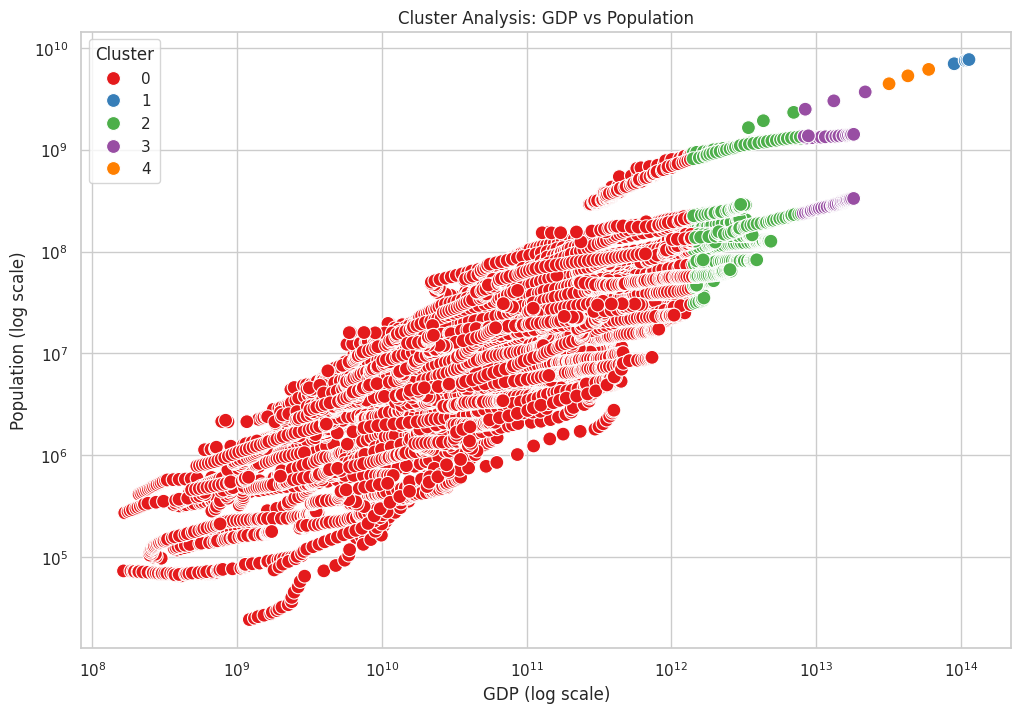

In [3]:

# Define specific energy types for key analysis
key_energy_types = ['coal_consumption', 'oil_consumption', 'gas_consumption', 
                    'nuclear_consumption', 'hydro_consumption', 'solar_consumption', 
                    'wind_consumption', 'other_renewable_consumption']
# Normalize the energy consumption data for clustering
energy_data_normalized = energy_data[key_energy_types].div(energy_data[key_energy_types].sum(axis=1), axis=0).fillna(0)

# Add GDP and population data for clustering
energy_data_for_clustering = energy_data_normalized.copy()
energy_data_for_clustering['gdp'] = energy_data['gdp']
energy_data_for_clustering['population'] = energy_data['population']
energy_data_for_clustering['country'] = energy_data['country']

# Filter out missing values - NA values
energy_data_for_clustering = energy_data_for_clustering.dropna(subset=['gdp', 'population'])

# Select only numeric data for KMeans clustering
numeric_data_for_clustering = energy_data_for_clustering[['gdp', 'population'] + key_energy_types]

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, n_init=10)  # 5 clusters
cluster_labels = kmeans.fit_predict(numeric_data_for_clustering)

# Assign the cluster labels to your DataFrame
energy_data_for_clustering['cluster'] = cluster_labels

# Cluster visualization
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.scatterplot(x='gdp', y='population', hue='cluster', data=energy_data_for_clustering, palette='Set1', s=100)
plt.title('Cluster Analysis: GDP vs Population')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('GDP (log scale)')
plt.ylabel('Population (log scale)')
plt.legend(title='Cluster', loc='upper left')
plt.show()


scatter plot displays countries clustered by their GDP and population, both on a logarithmic scale to accommodate the wide range of values. Five clusters are evident, with the red cluster representing many countries with lower GDP and populations, and the green, purple, and blue clusters corresponding to countries with higher GDPs, indicating various levels of economic development and population sizes. The distribution suggests that countries with higher GDPs often have larger populations, although there are notable exceptions, reflecting the diversity in economic structures and population dynamics globally.

In [4]:
# Select the most recent year's data for each country
most_recent_data = energy_data[energy_data['year'] == energy_data['year'].max()-1].copy()

# Handle NaN values and ensure all values are non-negative
most_recent_data[key_energy_types] = most_recent_data[key_energy_types].fillna(0).clip(lower=0)

# Normalize the data by dividing by the sum across each row
# Replace 'inf' values resulting from division by zero with NaN
sums = most_recent_data[key_energy_types].sum(axis=1).replace(0, np.nan)
most_recent_data_normalized = most_recent_data[key_energy_types].div(sums, axis=0)

# Ensure all columns in key_energy_types are numeric
for column in key_energy_types:
    most_recent_data_normalized[column] = pd.to_numeric(most_recent_data_normalized[column], errors='coerce')

# Define a function to get the predominant energy source
def get_predominant_energy_source(row):
    # Use a try-except block to handle any potential issues with idxmax
    try:
        return row.idxmax()
    except TypeError:
        return None

# Apply the function to determine the predominant energy source
most_recent_data['predominant_energy_source'] = most_recent_data_normalized.apply(get_predominant_energy_source, axis=1)

# Add country information to the normalized DataFrame
most_recent_data['country'] = most_recent_data['country']

# Create a DataFrame for energy source data
energy_source_data = most_recent_data[['country', 'predominant_energy_source']]

print(energy_source_data.head())


            country predominant_energy_source
121     Afghanistan                       NaN
243          Africa           oil_consumption
300     Africa (BP)           oil_consumption
322  Africa (Ember)                       NaN
682         Algeria           gas_consumption


/tmp/ipykernel_5942/2779321485.py:20: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return row.idxmax()
/tmp/ipykernel_5942/2779321485.py:20: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return row.idxmax()
/tmp/ipykernel_5942/2779321485.py:20: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return row.idxmax()
/tmp/ipykernel_5942/2779321485.py:20: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return row.idxmax()
/tmp/ipykernel_5942/2779321485.py:20: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprec

In [5]:
from sklearn.preprocessing import MinMaxScaler


# Handle NaN values for all columns at once
most_recent_data[key_energy_types] = most_recent_data[key_energy_types].apply(
    lambda column: column.fillna(0) if column.isna().all() else column.fillna(column.mean())
)

# Normalize the data
scaler = MinMaxScaler()
energy_profiles_normalized = pd.DataFrame(
    scaler.fit_transform(most_recent_data[key_energy_types]), 
    columns=key_energy_types, 
    index=most_recent_data.index
)

# Calculate the cosine similarity
similarity_matrix = cosine_similarity(energy_profiles_normalized)

# Create a DataFrame from the similarity matrix
countries = most_recent_data['country'].unique()  # List of countries
similarity_df = pd.DataFrame(similarity_matrix, index=countries, columns=countries)

print (similarity_df.head(20))


                     Afghanistan    Africa  Africa (BP)  Africa (Ember)  \
Afghanistan                  0.0  0.000000     0.000000             0.0   
Africa                       0.0  1.000000     1.000000             0.0   
Africa (BP)                  0.0  1.000000     1.000000             0.0   
Africa (Ember)               0.0  0.000000     0.000000             0.0   
Algeria                      0.0  0.700504     0.700504             0.0   
American Samoa               0.0  0.000000     0.000000             0.0   
Angola                       0.0  0.000000     0.000000             0.0   
Antigua and Barbuda          0.0  0.000000     0.000000             0.0   
Argentina                    0.0  0.855113     0.855113             0.0   
Armenia                      0.0  0.000000     0.000000             0.0   
Aruba                        0.0  0.000000     0.000000             0.0   
Asia                         0.0  0.856853     0.856853             0.0   
Asia (Ember)             

### Plot

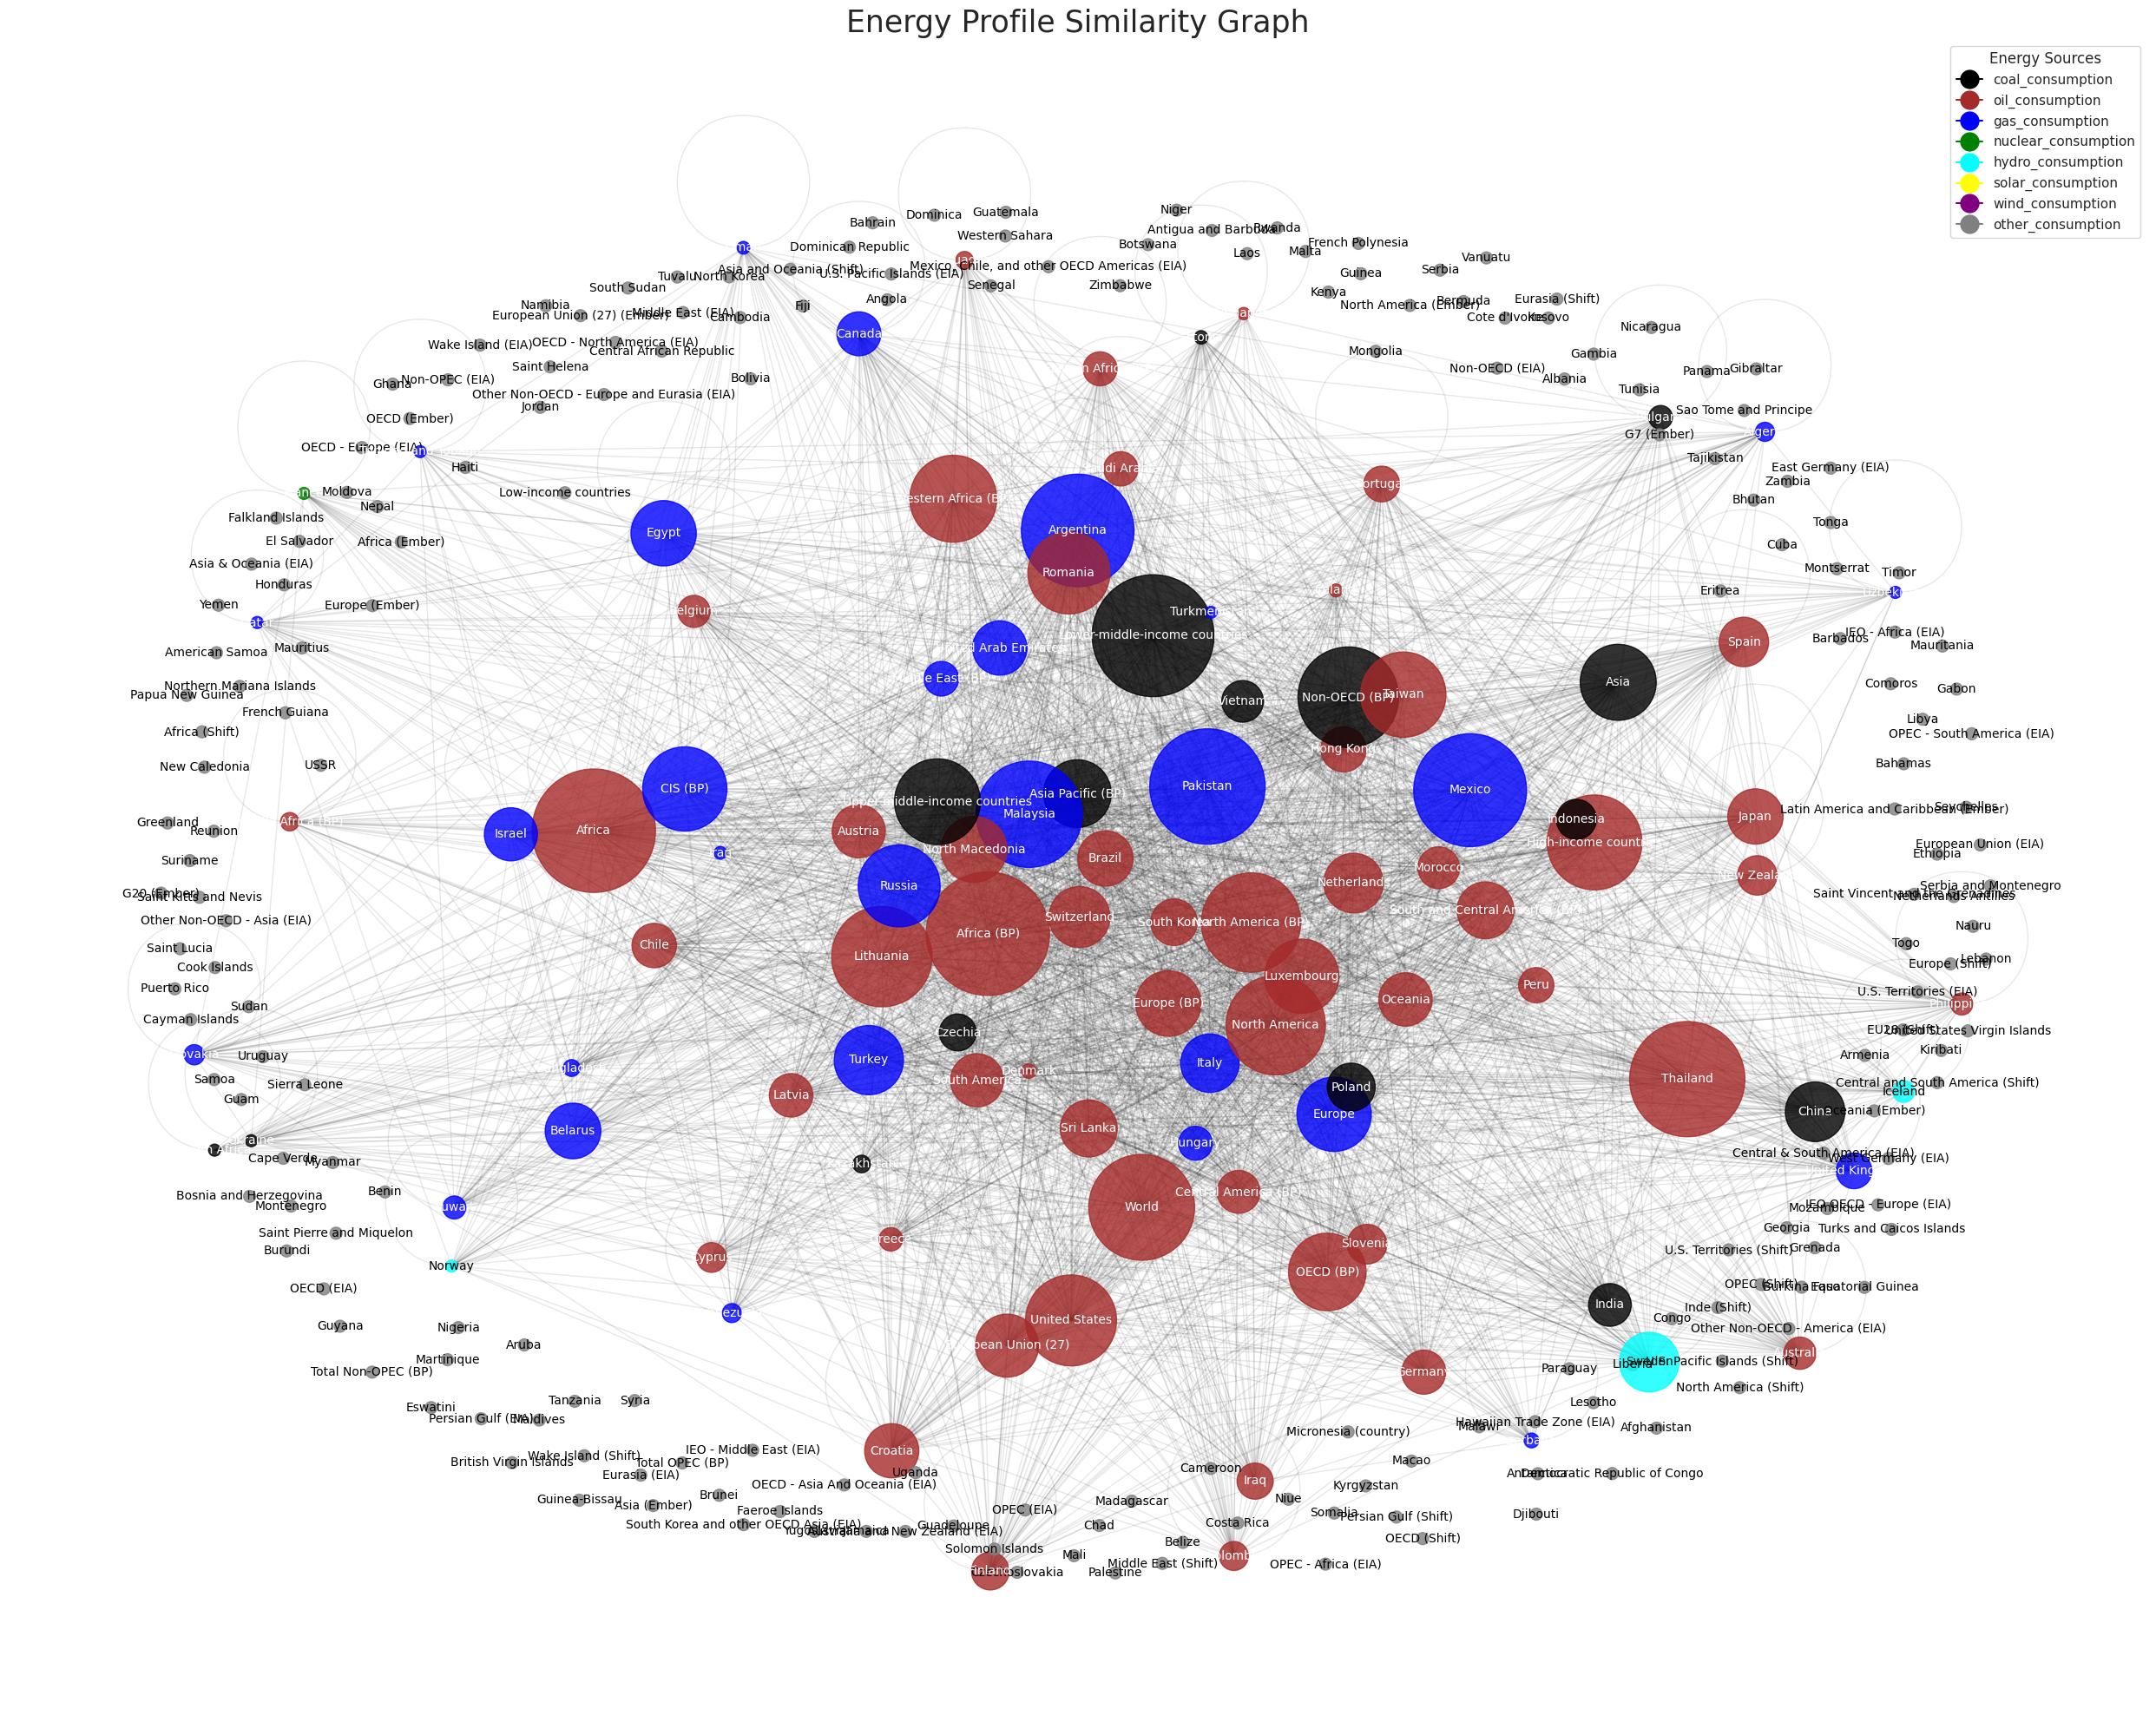

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

# Define your colors for each energy source
energy_source_colors = {
    'coal_consumption': 'black',
    'oil_consumption': 'brown',
    'gas_consumption': 'blue',
    'nuclear_consumption': 'green',
    'hydro_consumption': 'cyan',
    'solar_consumption': 'yellow',
    'wind_consumption': 'purple',
    'other_consumption': 'grey'}

# function to choose text color based on node color for better contrast
def get_text_color(background_color):
    # Colors for which white text is not preferred
    light_colors = ['cyan', 'yellow', 'white', 'grey']
    if background_color in light_colors:
        return 'black'  # Dark text for light backgrounds
    else:
        return 'white'  # White text for dark backgrounds


G = nx.Graph()

# Add nodes for each country
for country in energy_data['country']:
    G.add_node(country)

# Add edges based on similarity in energy profiles
threshold = 0.5  # threshold for similarity to add an edge
for i in similarity_df.index:
    for j in similarity_df.columns:
        if similarity_df.loc[i, j] > threshold:
            G.add_edge(i, j)

# Calculate centrality
centrality = nx.betweenness_centrality(G)

# Adjust k and iterations as needed
pos = nx.spring_layout(G, k=1.85, iterations=50)

plt.figure(figsize=(25, 20))  # Adjust figure size as needed

# Adjust the multiplier for node size
node_size = [centrality[node] * 5000000 for node in G.nodes()]

# Assign a color to each node based on its predominant energy source
for node in G.nodes():
    # Find the predominant energy source for the country (node)
    if node in energy_source_data['country'].values:
        predominant_source = energy_source_data[energy_source_data['country']
                                                == node]['predominant_energy_source'].iloc[0]
        node_color = energy_source_colors.get(
            predominant_source, 'grey')  # Default to 'grey' if not found
    else:
        node_color = 'grey'  # Assign 'grey' if country is not in energy_source_data
    # Assign the color to the node
    G.nodes[node]['color'] = node_color

# Draw nodes with the assigned colors and sizes, with alpha set to 0.8
nodes = nx.draw_networkx_nodes(
    G, pos,
    # Ensure nodes are at least min_node_size (100)
    node_size=[max(size, 100) for size in node_size],
    node_color=[data['color'] for _, data in G.nodes(data=True)],
    alpha=0.8  # Node transparency set to 0.8
)

# Draw edges
edges = nx.draw_networkx_edges(G, pos, alpha=0.1)

# Create a dictionary for node labels with their respective text colors
node_labels = {node: node for node in G.nodes()}
text_colors = {node: get_text_color(
    G.nodes[node]['color']) for node in G.nodes()}

# Draw labels with the chosen text colors
for node, label_pos in pos.items():
    x, y = label_pos
    plt.text(x, y, node, fontsize=10,
             color=text_colors[node], ha='center', va='center')

# Add a legend for energy sources
legend_elements = [
    plt.Line2D([0], [0], marker='o', color=color, label=source,
               markersize=15, markerfacecolor=color)
    for source, color in energy_source_colors.items()
]
plt.legend(handles=legend_elements, title="Energy Sources",
           loc='best', bbox_to_anchor=(1, 1))

plt.title("Energy Profile Similarity Graph", size=25)
plt.axis('off')
plt.tight_layout()  # Spread out the layout a bit more
plt.show()

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

plt.figure(figsize=(25, 20))  # Adjust figure size as needed

# Use the Louvain method to find the best partition for community detection
partition = community_louvain.best_partition(G)

# Create a color map for the communities
community_ids = list(set(partition.values()))
community_colors = [partition.get(node) for node in G.nodes()]
# Map community to color
community_color_map = plt.cm.Spectral(np.linspace(0, 1, len(community_ids)))

nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=[max(size, 100) for size in node_size],  # Ensure nodes are at least min_node_size
    node_color=community_colors,  
    cmap=plt.cm.Spectral,  
    alpha=0.8  
)

# Draw edges with lower opacity to focus on nodes
edges = nx.draw_networkx_edges(G, pos, alpha=0.1)

# Draw labels with a smaller font size
labels = nx.draw_networkx_labels(G, pos, font_size=8)

# Create a colorbar for the community colors
norm = Normalize(vmin=min(community_colors), vmax=max(community_colors))
sm = ScalarMappable(norm=norm, cmap=plt.cm.Spectral)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label('Community ID')

plt.title("Energy Profile Similarity Graph with Community Detection", size=25)
plt.axis('off')
plt.tight_layout(rect=[0, 0, 0.9, 1]) 
plt.show()


AttributeError: module 'community' has no attribute 'best_partition'

<Figure size 2500x2000 with 0 Axes>

Let's find the ammount of communities using the greedy modularity maximization... (Greedy modularity maximization begins with each node in its own community and repeatedly joins the pair of communities that lead to the largest modularity until no further increase in modularity is possible. Once it is maximised the algorithm stops.)

In [36]:
from networkx.algorithms.community import greedy_modularity_communities

# Use the greedy modularity community detection algorithm
communities = greedy_modularity_communities(G)
print('Number of communities found: {}'.format(len(communities)))

Number of communities found: 206


In [37]:
from networkx.algorithms.community.quality import modularity

# Compute the modularity of the partition
modularity_value = modularity(G, communities)
print('Modularity value: {}'.format(modularity_value))



Modularity value: 0.16413650527967633


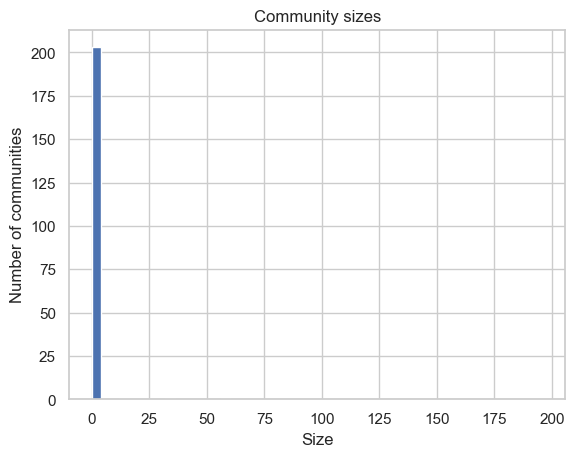

In [38]:
# plot distribution of community sizes
import matplotlib.pyplot as plt
import numpy as np
sizes = [len(community) for community in communities]
plt.hist(sizes, bins=np.arange(0, 200, 4))
plt.title('Community sizes')
plt.xlabel('Size')
plt.ylabel('Number of communities')
plt.show()